In [8]:
# Import libraries
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_swiss_roll
from tqdm import tqdm

# Set device & seed
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print("="*60)

Device: cpu


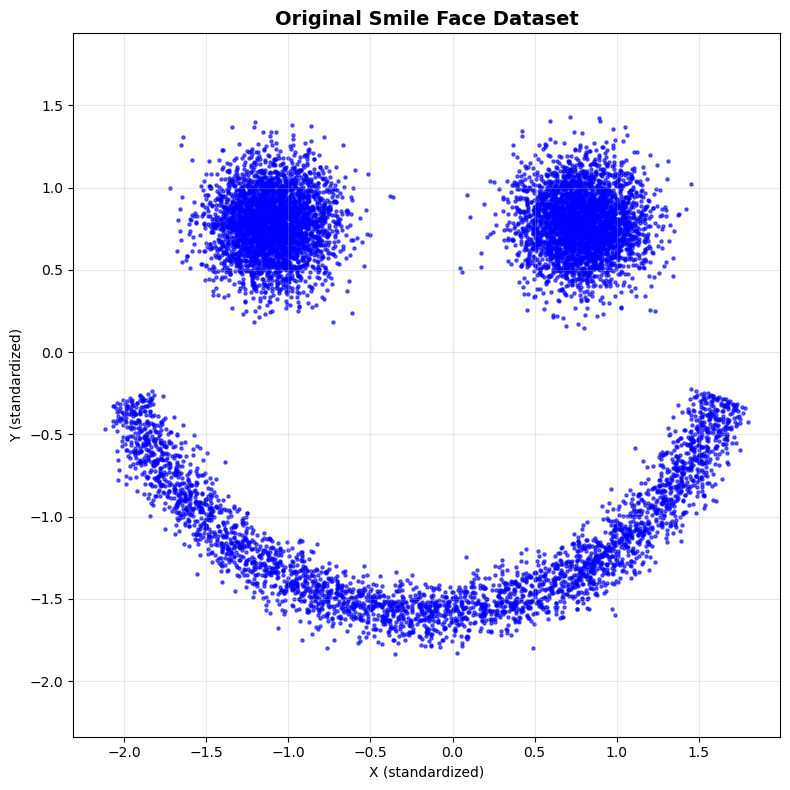

Dataset shape: torch.Size([9999, 2])
Range: X∈[-2.11, 1.80], Y∈[-1.83, 1.43]


In [9]:
# Generate Smile Face dataset
def make_smile(n_samples=10000):
    n_part = n_samples // 3 # Dibagi 3: Mata Kiri, Mata Kanan, Mulut
    
    # Left Eye (Gaussian Blob)
    x1 = np.random.normal(-1.0, 0.2, n_part)
    y1 = np.random.normal(1.0, 0.2, n_part)
    
    # Right Eye (Gaussian Blob)
    x2 = np.random.normal(1.0, 0.2, n_part)
    y2 = np.random.normal(1.0, 0.2, n_part)
    
    # Mouth (Lower arc / Smile)
    theta = np.random.uniform(1.1*np.pi, 1.9*np.pi, n_part)
    r = 2.0 + np.random.normal(0, 0.1, n_part)
    x3 = r * np.cos(theta)
    y3 = r * np.sin(theta) + 0.5 # Shift up slightly
    
    x = np.concatenate([x1, x2, x3])
    y = np.concatenate([y1, y2, y3])
    data = np.stack([x, y], axis=1)
    return data

x = make_smile(10000)

# Normalize
x = (x - x.mean()) / x.std()
X = torch.tensor(x, dtype=torch.float32)

# Visualize original data
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0], x[:, 1], s=5, alpha=0.6, c='blue')
plt.title("Original Smile Face Dataset", fontsize=14, fontweight='bold')
plt.xlabel("X (standardized)")
plt.ylabel("Y (standardized)")
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Dataset shape: {X.shape}")
print(f"Range: X∈[{X[:,0].min():.2f}, {X[:,0].max():.2f}], Y∈[{X[:,1].min():.2f}, {X[:,1].max():.2f}]")

## PART 2: Define VP-SDE

In [10]:
class VPSDE:
    """Variance Preserving SDE: dx = -0.5*β(t)*x dt + √β(t) dw"""
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
        
    def beta(self, t):
        if not torch.is_tensor(t):
            t = torch.tensor(t, dtype=torch.float32)
        return self.beta_min + t * (self.beta_max - self.beta_min)
    
    def mean_coeff(self, t):
        if not torch.is_tensor(t):
            t = torch.tensor(t, dtype=torch.float32)
        integral = -0.25 * t**2 * (self.beta_max - self.beta_min) - 0.5 * t * self.beta_min
        return torch.exp(integral)
    
    def std(self, t):
        if not torch.is_tensor(t):
            t = torch.tensor(t, dtype=torch.float32)
        return torch.sqrt(1 - self.mean_coeff(t)**2)
    
    def marginal_prob(self, x0, t):
        mean = self.mean_coeff(t) * x0
        std = self.std(t)
        return mean, std
    
    def prior_sampling(self, shape):
        return torch.randn(*shape)

sde = VPSDE(beta_min=0.1, beta_max=20.0, T=1.0)
print("VP-SDE initialized")
print(f"β(t) = {sde.beta_min} + t × {sde.beta_max - sde.beta_min}")

VP-SDE initialized
β(t) = 0.1 + t × 19.9


## PART 3: Forward SDE Visualization (Data → Noise)

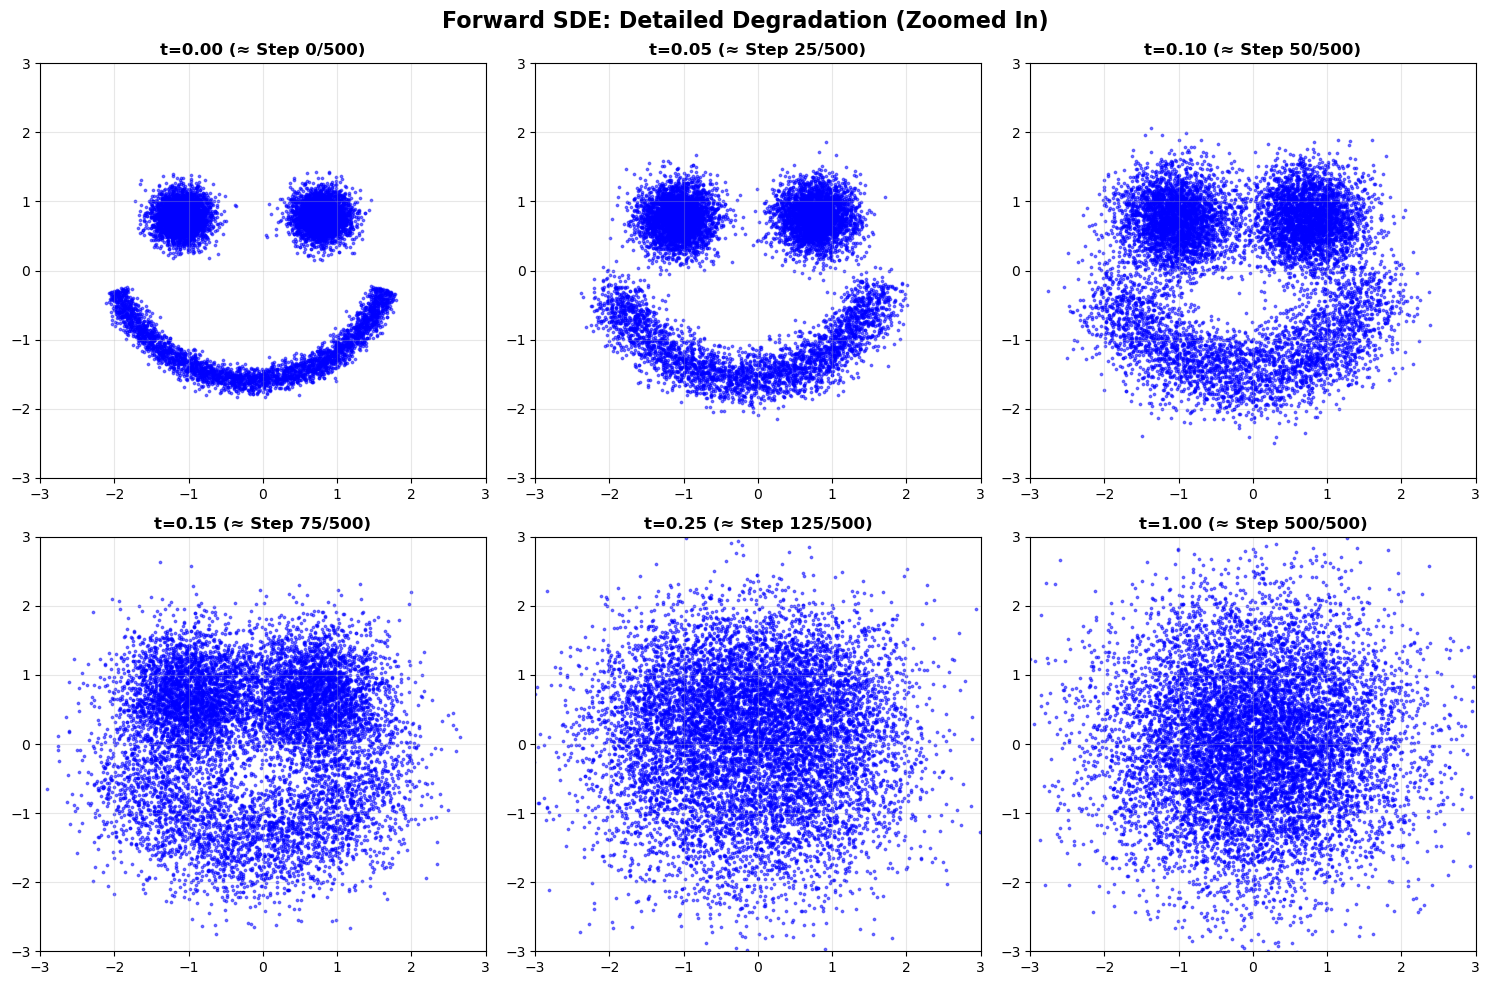

Forward SDE visualization complete
Note: t=1.0 adalah waktu kontinu akhir. Kita membaginya menjadi 500 langkah diskrit.


In [11]:
# Visualize forward noising process
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# UBAH TIMESTEPS: Fokus pada area di mana struktur data mulai hancur (t kecil)
timesteps = [0.0, 0.05, 0.1, 0.15, 0.25, 1.0]

# Kita gunakan 500 langkah dalam sampler nanti, jadi kita pakai angka itu untuk estimasi
TOTAL_STEPS = 500 

for idx, t_val in enumerate(timesteps):
    ax = axes[idx // 3, idx % 3]
    
    t = torch.tensor([t_val])
    mean, std = sde.marginal_prob(X, t)
    
    # Sample noisy data
    noise = torch.randn_like(X)
    x_t = mean + std * noise
    
    # Hitung estimasi step berdasarkan total step yang kita pilih (500)
    step_equiv = int(t_val * TOTAL_STEPS)
    
    ax.scatter(x_t[:, 0], x_t[:, 1], s=3, alpha=0.5, c='blue')
    ax.set_title(f't={t_val:.2f} (≈ Step {step_equiv}/{TOTAL_STEPS})', fontweight='bold')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.grid(True, alpha=0.3)

plt.suptitle('Forward SDE: Detailed Degradation (Zoomed In)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Forward SDE visualization complete")
print(f"Note: t=1.0 adalah waktu kontinu akhir. Kita membaginya menjadi {TOTAL_STEPS} langkah diskrit.")

## PART 4: Train Score Model

In [12]:
class ScoreNetwork(nn.Module):
    """Neural network to predict score function: s_θ(x,t) ≈ ∇log p_t(x)"""
    def __init__(self, input_dim=2, hidden_dim=256, num_layers=6, time_embed_dim=64): # Meningkatkan kapasitas model
        super(ScoreNetwork, self).__init__()
        
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )
        
        self.input_layer = nn.Linear(input_dim + time_embed_dim, hidden_dim)
        
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
            )
            for _ in range(num_layers)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        self.norms = nn.ModuleList([nn.GroupNorm(8, hidden_dim) for _ in range(num_layers)])
        
    def forward(self, x, t):
        t_embed = self.time_embed(t)
        h = torch.cat([x, t_embed], dim=-1)
        h = self.input_layer(h)
        h = nn.functional.silu(h)
        
        for layer, norm in zip(self.hidden_layers, self.norms):
            h_res = layer(h)
            h_res = norm(h_res)
            h = h + h_res
            h = nn.functional.silu(h)
        
        return self.output_layer(h)

score_model = ScoreNetwork(input_dim=2, hidden_dim=256, num_layers=6).to(device) # Update parameter inisialisasi
print(f"Score model created | Parameters: {sum(p.numel() for p in score_model.parameters()):,}")

Score model created | Parameters: 814,530


In [13]:
def score_matching_loss(score_model, sde, x_batch, eps=1e-5):
    """Denoising Score Matching Loss"""
    batch_size = x_batch.shape[0]
    t = torch.rand(batch_size, 1).to(device) * (sde.T - eps) + eps
    
    mean, std = sde.marginal_prob(x_batch, t)
    z = torch.randn_like(x_batch).to(device)
    x_t = mean + std * z
    
    predicted_score = score_model(x_t, t)
    true_score = -z / std
    
    loss = torch.mean(std**2 * torch.sum((predicted_score - true_score)**2, dim=-1))
    return loss

# Test loss
test_batch = X[:64].to(device)
test_loss = score_matching_loss(score_model, sde, test_batch)
print(f"Initial loss: {test_loss.item():.4f}")

Initial loss: 36.7586



Training: 500 epochs, batch size 512


Training: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]




Training complete | Final loss: 50.0226


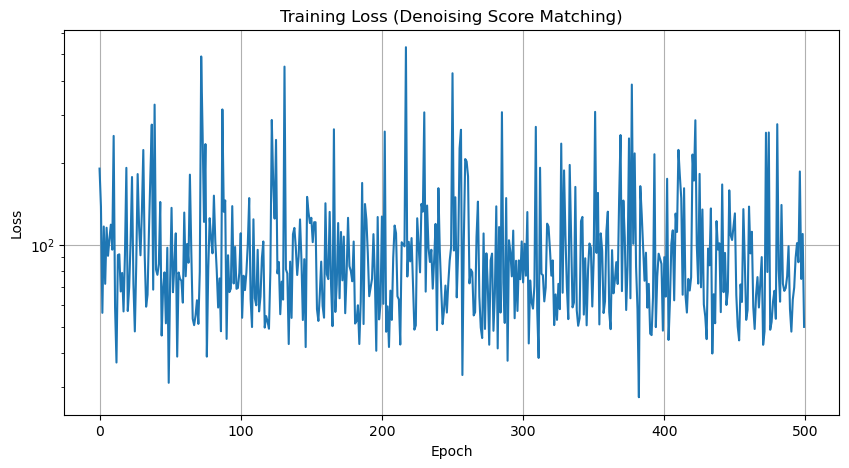

In [14]:
# Training
n_epochs = 500  # Meningkatkan jumlah epoch dari 150 ke 500
batch_size = 512
learning_rate = 1e-3  # Sedikit menaikkan learning rate (sebelumnya 2e-4)

optimizer = optim.Adam(score_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

losses = []
score_model.train()

print(f"\nTraining: {n_epochs} epochs, batch size {batch_size}")
print("="*60)

for epoch in tqdm(range(n_epochs), desc="Training"):
    epoch_loss = 0.0
    n_batches = 0
    perm = torch.randperm(len(X))
    
    for i in range(0, len(X), batch_size):
        idx = perm[i:i+batch_size]
        x_batch = X[idx].to(device)
        
        loss = score_matching_loss(score_model, sde, x_batch)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(score_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    scheduler.step()
    avg_loss = epoch_loss / n_batches
    losses.append(avg_loss)

print(f"\nTraining complete | Final loss: {losses[-1]:.4f}")

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Denoising Score Matching)')
plt.yscale('log')
plt.grid(True)
plt.show()

## PART 5: Reverse SDE Visualization (Noise → Data)

Generating samples with trajectory...


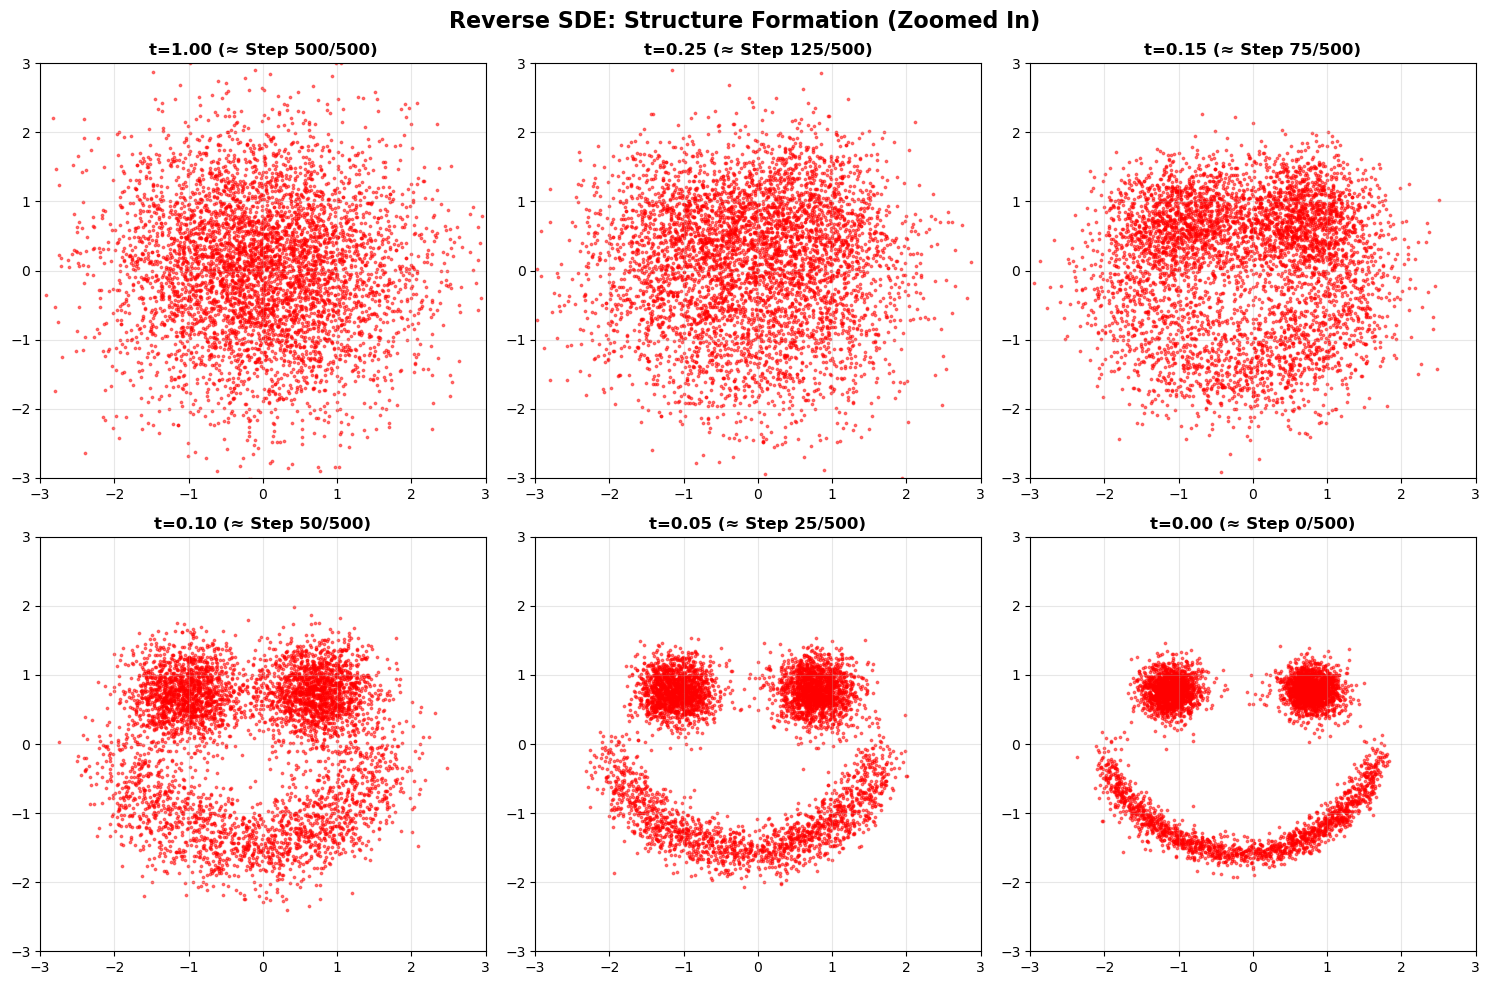

Generated 5000 samples using 500 Euler-Maruyama steps


In [15]:
def euler_maruyama_sampler(score_model, sde, num_samples, num_steps=500, eps=1e-3, save_trajectory=True):
    """Generate samples using Euler-Maruyama method"""
    score_model.eval()
    
    # Tentukan waktu snapshot yang ingin disimpan (kebalikan dari forward)
    snapshot_ts = [1.0, 0.25, 0.15, 0.1, 0.05, eps]
    
    with torch.no_grad():
        x = sde.prior_sampling((num_samples, 2)).to(device)
        t_steps = torch.linspace(1.0, eps, num_steps).to(device)
        
        trajectory = []
        snapshot_indices = []
        
        # Cari index step yang paling mendekati waktu snapshot
        if save_trajectory:
            for t_snap in snapshot_ts:
                idx = (torch.abs(t_steps - t_snap)).argmin().item()
                snapshot_indices.append(idx)
        
        for i, t in enumerate(t_steps):
            t_batch = t.repeat(num_samples).reshape(-1, 1)
            score = score_model(x, t_batch)
            
            beta_t = sde.beta(t)
            
            # Euler-Maruyama step
            drift = (beta_t / num_steps) * (0.5 * x + score)
            diffusion = torch.sqrt(beta_t / num_steps) * torch.randn_like(x)
            
            x = x + drift + diffusion
            
            if save_trajectory and i in snapshot_indices:
                trajectory.append(x.cpu().clone())
        
        if save_trajectory and len(trajectory) < len(snapshot_ts):
             trajectory.append(x.cpu().clone())

        if save_trajectory:
            return x.cpu(), trajectory, snapshot_ts
        return x.cpu()

# Generate samples and save trajectory
# Kita menggunakan 500 langkah (num_steps=500)
print("Generating samples with trajectory...")
X_generated, trajectory, snap_times = euler_maruyama_sampler(score_model, sde, 5000, num_steps=500, save_trajectory=True)

# Visualize reverse process
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

TOTAL_STEPS = 500 # Konsisten dengan num_steps di atas

for idx, (t_val, traj_data) in enumerate(zip(snap_times, trajectory)):
    if idx >= 6: break 
    ax = axes[idx // 3, idx % 3]
    ax.scatter(traj_data[:, 0], traj_data[:, 1], s=3, alpha=0.5, c='red')
    
    step_equiv = int(t_val * TOTAL_STEPS)
    ax.set_title(f't={t_val:.2f} (≈ Step {step_equiv}/{TOTAL_STEPS})', fontweight='bold')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.grid(True, alpha=0.3)

plt.suptitle('Reverse SDE: Structure Formation (Zoomed In)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Generated {len(X_generated)} samples using {TOTAL_STEPS} Euler-Maruyama steps")

## PART 6: Final Comparison

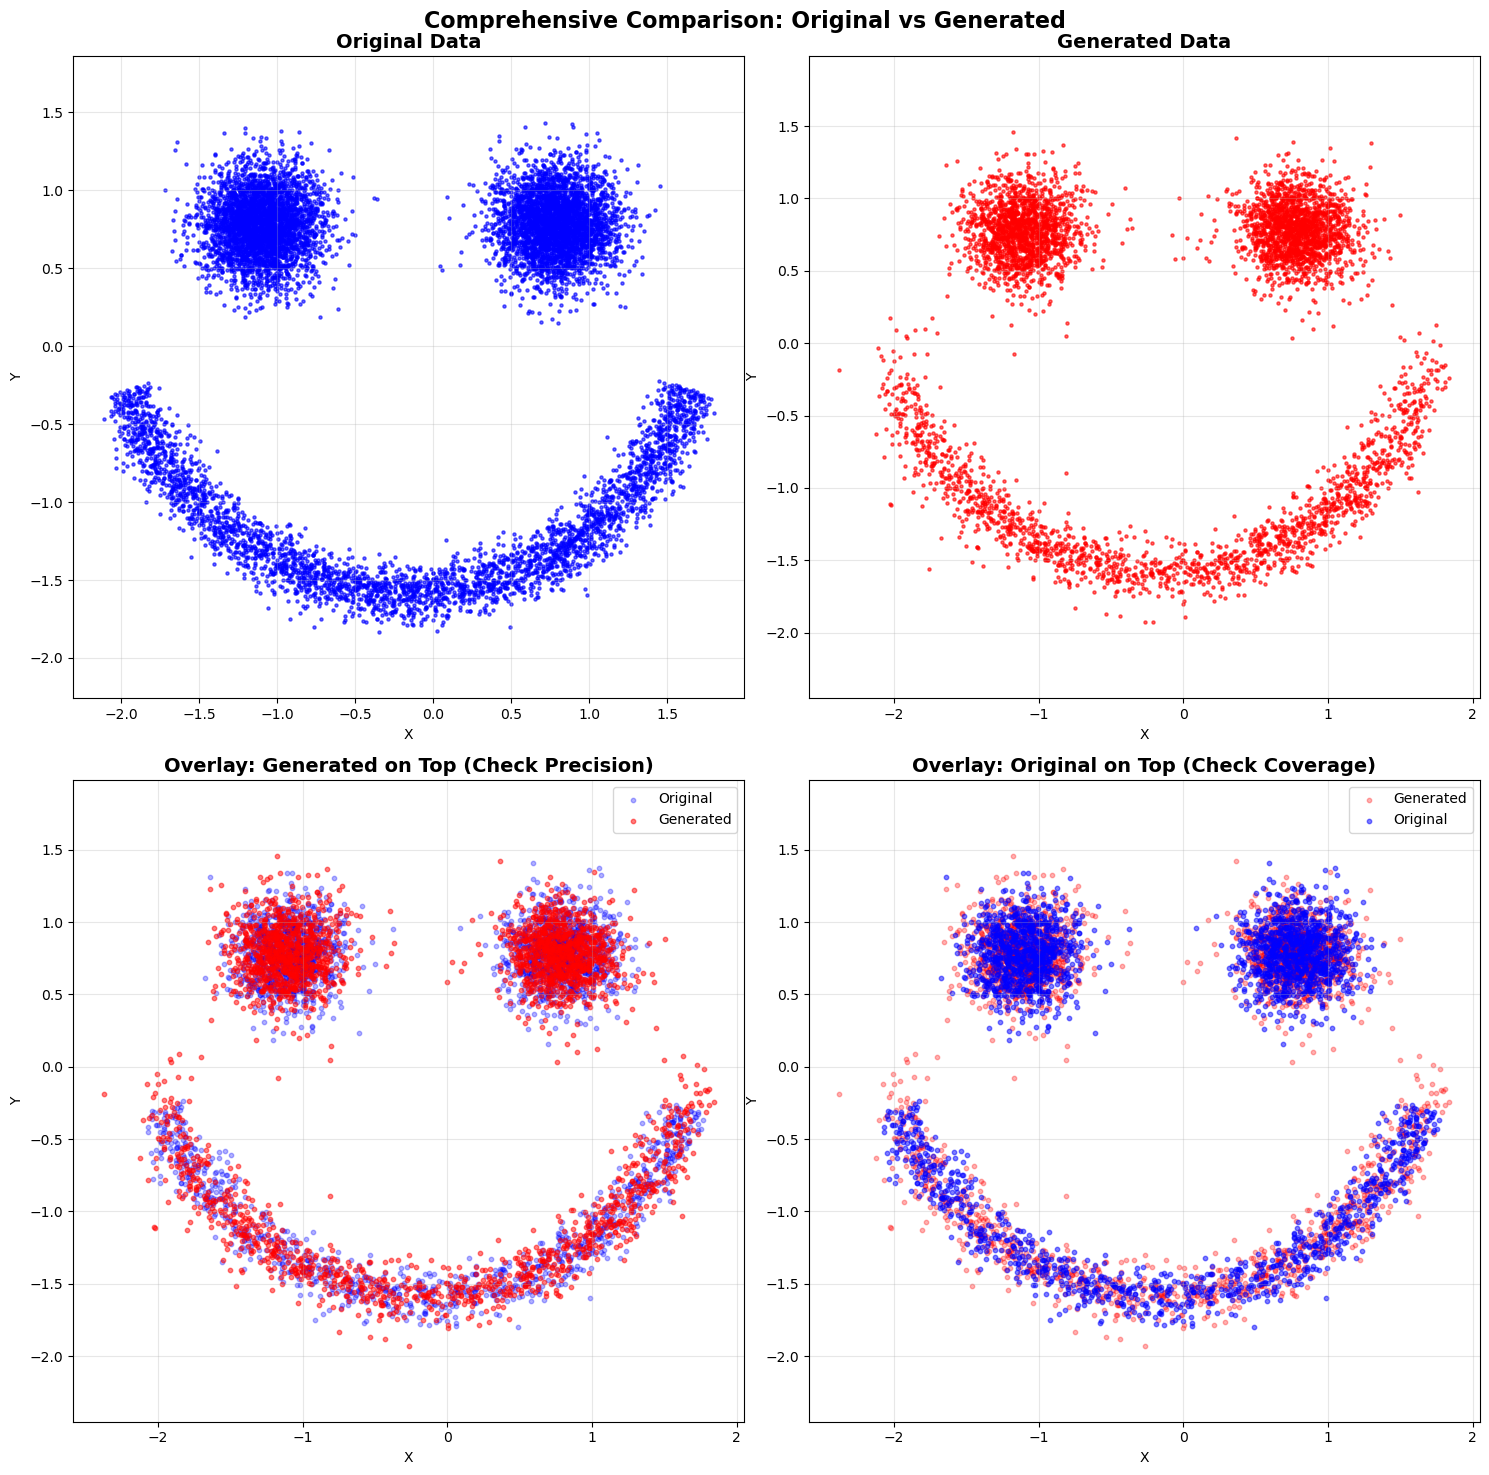

EVALUATION: ORIGINAL VS GENERATED
Original  - Mean: [-0.145, 0.145] | Std: [1.035, 0.942]
Generated - Mean: [-0.121, 0.136] | Std: [1.039, 0.944]

Original  - Range: X∈[-2.11, 1.80], Y∈[-1.83, 1.43]
Generated - Range: X∈[-2.38, 1.84], Y∈[-1.93, 1.46]


In [18]:
# Compare original vs generated
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Prepare subsets for overlay (Shuffle X to ensure all parts are represented)
# Penting: X[:3000] bisa saja hanya mengambil satu bagian (misal mata kiri) jika data tidak di-shuffle
perm = torch.randperm(len(X))
X_subset = X[perm[:3000]]
X_gen_subset = X_generated[:3000]

# 1. Original Data
axes[0, 0].scatter(X[:, 0], X[:, 1], s=5, alpha=0.6, c='blue')
axes[0, 0].set_title('Original Data', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('Y')
axes[0, 0].axis('equal')
axes[0, 0].grid(True, alpha=0.3)

# 2. Generated Data
axes[0, 1].scatter(X_generated[:, 0], X_generated[:, 1], s=5, alpha=0.6, c='red')
axes[0, 1].set_title('Generated Data', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('X')
axes[0, 1].set_ylabel('Y')
axes[0, 1].axis('equal')
axes[0, 1].grid(True, alpha=0.3)

# 3. Overlay: Original (Bottom) vs Generated (Top)
# Membantu melihat apakah data yang digenerate berada di tempat yang benar (Presisi)
# Jika titik merah menutupi biru dengan pas, berarti posisinya akurat.
axes[1, 0].scatter(X_subset[:, 0], X_subset[:, 1], s=10, alpha=0.3, c='blue', label='Original')
axes[1, 0].scatter(X_gen_subset[:, 0], X_gen_subset[:, 1], s=10, alpha=0.5, c='red', label='Generated')
axes[1, 0].set_title('Overlay: Generated on Top (Check Precision)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Y')
axes[1, 0].axis('equal')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4. Overlay: Generated (Bottom) vs Original (Top)
# Membantu melihat apakah seluruh area data asli tercover oleh hasil generate (Coverage)
# Jika masih banyak warna biru yang terlihat jelas (tidak tertutup merah di bawahnya), berarti ada mode collapse (bagian data yang gagal ditiru).
axes[1, 1].scatter(X_gen_subset[:, 0], X_gen_subset[:, 1], s=10, alpha=0.3, c='red', label='Generated')
axes[1, 1].scatter(X_subset[:, 0], X_subset[:, 1], s=10, alpha=0.5, c='blue', label='Original')
axes[1, 1].set_title('Overlay: Original on Top (Check Coverage)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('Y')
axes[1, 1].axis('equal')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.suptitle('Comprehensive Comparison: Original vs Generated', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistics
print("="*60)
print("EVALUATION: ORIGINAL VS GENERATED")
print("="*60)
print(f"Original  - Mean: [{X[:,0].mean():.3f}, {X[:,1].mean():.3f}] | Std: [{X[:,0].std():.3f}, {X[:,1].std():.3f}]")
print(f"Generated - Mean: [{X_generated[:,0].mean():.3f}, {X_generated[:,1].mean():.3f}] | Std: [{X_generated[:,0].std():.3f}, {X_generated[:,1].std():.3f}]")
print(f"\nOriginal  - Range: X∈[{X[:,0].min():.2f}, {X[:,0].max():.2f}], Y∈[{X[:,1].min():.2f}, {X[:,1].max():.2f}]")
print(f"Generated - Range: X∈[{X_generated[:,0].min():.2f}, {X_generated[:,0].max():.2f}], Y∈[{X_generated[:,1].min():.2f}, {X_generated[:,1].max():.2f}]")